## <a name="C4">0. Importation et fonctions</a>

### 0.1 Importation des librairies

In [24]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

import scipy.stats as st

### 0.2 Importation des données

In [25]:
raw_df = pd.read_csv('data/2016_Building_Energy_Benchmarking.csv', low_memory=False)

In [26]:
def filter_out_outliers(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df[var] >= Q1 - 1.5 * IQR) & (df[var] <= Q3 + 1.5 *IQR)
    return df[filter]

## <a name="C4">1. Préparation des données</a>

### 1.1 Variables inutiles

In [27]:
raw_df.shape

(3376, 46)

In [28]:
raw_df.T

0     \
OSEBuildingID                                       1   
DataYear                                         2016   
BuildingType                           NonResidential   
PrimaryPropertyType                             Hotel   
PropertyName                     Mayflower park hotel   
Address                                 405 Olive way   
City                                          Seattle   
State                                              WA   
ZipCode                                       98101.0   
TaxParcelIdentificationNumber              0659000030   
CouncilDistrictCode                                 7   
Neighborhood                                 DOWNTOWN   
Latitude                                      47.6122   
Longitude                                  -122.33799   
YearBuilt                                        1927   
NumberofBuildings                                 1.0   
NumberofFloors                                     12   
PropertyGFATotal                                88434   
PropertyGFAParking                                  0   
PropertyGFABuilding(s)                          88434   
ListOfAllPropertyUseTypes                       Hotel   
LargestPropertyUseType                          Hotel   
LargestPropertyUseTypeGFA                     88434.0   
SecondLargestPropertyUseType                      NaN   
SecondLargestPropertyUseTypeGFA                   NaN   
ThirdLargestPropertyUseType                       NaN   
ThirdLargestPropertyUseTypeGFA                    NaN   
YearsENERGYSTARCertified                          NaN   
ENERGYSTARScore                                  60.0   
SiteEUI(kBtu/sf)                            81.699997   
SiteEUIWN(kBtu/sf)                          84.300003   
SourceEUI(kBtu/sf)                              182.5   
SourceEUIWN(kBtu/sf)                            189.0   
SiteEnergyUse(kBtu)                         7226362.5   
SiteEnergyUseWN(kBtu)                       7456910.0   
SteamUse(kBtu)                              2003882.0   
Electricity(kWh)                           1156514.25   
Electricity(kBtu)                           3946027.0   
NaturalGas(therms)                         12764.5293   
NaturalGas(kBtu)                            1276453.0   
DefaultData                                     False   
Comments                                          NaN   
ComplianceStatus                            Compliant   
Outlier                                           NaN   
TotalGHGEmissions                              249.98   
GHGEmissionsIntensity                            2.83   

                                                       1     \
OSEBuildingID                                             2   
DataYear                                               2016   
BuildingType                                 NonResidential   
PrimaryPropertyType                                   Hotel   
PropertyName                                Paramount Hotel   
Address                                     724 Pine street   
City                                                Seattle   
State                                                    WA   
ZipCode                                             98101.0   
TaxParcelIdentificationNumber                    0659000220   
CouncilDistrictCode                                       7   
Neighborhood                                       DOWNTOWN   
Latitude                                           47.61317   
Longitude                                        -122.33393   
YearBuilt                                              1996   
NumberofBuildings                                       1.0   
NumberofFloors                                           11   
PropertyGFATotal                                     103566   
PropertyGFAParking                                    15064   
PropertyGFABuilding(s)                                88502   
ListOfAllPropertyUseTypes        Hotel, Parkin

In [29]:
df = raw_df

In [30]:
df.DataYear.value_counts()

DataYear
2016    3376
Name: count, dtype: int64

In [31]:
irrelevant_domain_vars = [
    'OSEBuildingID',
     'DataYear',
     'PropertyName',
     'Address',
     'City',
     'State',
     'TaxParcelIdentificationNumber',
     'DefaultData',
     'Comments'
]

In [32]:
df = df.drop(irrelevant_domain_vars, axis=1)

Les informations contenues dans ces variables n'ont aucune valeur prédictive; je les supprime.

In [33]:
duplicate_energy_vars = [
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)', 
    'SiteEnergyUseWN(kBtu)', 
    'Electricity(kWh)',
    'NaturalGas(therms)',
]

In [34]:
df = df.drop(columns=duplicate_energy_vars)

Ces variables sont en doublon d'autres variables de relevé énergetique. Je choisis de garder une unité commune (le kBtu).

In [35]:
df.shape

(3376, 30)

### 1.2 Variables inexploitables

In [36]:
df.isnull().sum()

BuildingType                          0
PrimaryPropertyType                   0
ZipCode                              16
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697
ThirdLargestPropertyUseType        2780
ThirdLargestPropertyUseTypeGFA     2780
YearsENERGYSTARCertified           3257
ENERGYSTARScore                     843
SiteEnergyUse(kBtu)                   5
SteamUse(kBtu)                        9
Electricity(kBtu)                     9


In [37]:
df = df.drop(columns=[
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA', 
    'ThirdLargestPropertyUseType', 
    'ThirdLargestPropertyUseTypeGFA',
    'YearsENERGYSTARCertified',
])

Je supprime les colonnes ayant trop de valeurs manquantes pour réaliser une imputation.

In [38]:
for var in df.columns:
    if df[var].isnull().sum() <= 20:
        df = df[~df[var].isnull()]

Je supprime les observations manquantes pour les variables ayant un taux très faible de valeurs manquantes, me permettant de garder un dataset fourni.

In [39]:
df['MissingENERGYSTARScore'] = False
df.loc[df.ENERGYSTARScore.isnull(), 'MissingENERGYSTARScore'] = True
df.loc[df.ENERGYSTARScore.isnull(), 'ENERGYSTARScore'] = df.ENERGYSTARScore.median()

J'impute l'ENERGY STAR Score par la médiane, et garde une trace des valeurs manquantes.

In [40]:
df.isnull().sum()

BuildingType                    0
PrimaryPropertyType             0
ZipCode                         0
CouncilDistrictCode             0
Neighborhood                    0
Latitude                        0
Longitude                       0
YearBuilt                       0
NumberofBuildings               0
NumberofFloors                  0
PropertyGFATotal                0
PropertyGFAParking              0
PropertyGFABuilding(s)          0
ListOfAllPropertyUseTypes       0
LargestPropertyUseType          0
LargestPropertyUseTypeGFA       0
ENERGYSTARScore                 0
SiteEnergyUse(kBtu)             0
SteamUse(kBtu)                  0
Electricity(kBtu)               0
NaturalGas(kBtu)                0
ComplianceStatus                0
Outlier                      3308
TotalGHGEmissions               0
GHGEmissionsIntensity           0
MissingENERGYSTARScore          0
dtype: int64

In [41]:
df.shape

(3340, 26)

### 1.3 Valeurs hors du cadre du projet

Le projet se concentre sur les batîments non destinés à l'habitation. Il semble qu'une partie du dataset concerne ces bâtiments:

In [42]:
df.BuildingType.value_counts()

BuildingType
NonResidential          1454
Multifamily LR (1-4)    1007
Multifamily MR (5-9)     579
Multifamily HR (10+)     108
SPS-District K-12         98
Nonresidential COS        69
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [43]:
non_housing_mask = ~(df.BuildingType.str.contains('Multifamily')) & ~(df.LargestPropertyUseType.fillna('Empty').str.contains('Multifamily'))
len(df) - len(df[non_housing_mask])

1706

In [44]:
df.BuildingType.value_counts()

BuildingType
NonResidential          1454
Multifamily LR (1-4)    1007
Multifamily MR (5-9)     579
Multifamily HR (10+)     108
SPS-District K-12         98
Nonresidential COS        69
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [45]:
df = df[df.BuildingType.str.contains('NonResidential')]

A peu près la moitié des observations du dataset concernent des logements. Je les supprime.

### 1.4 Export du jeu de données nettoyé

J'exporte le jeu de données nettoyé, pour pouvoir réaliser la modélisation dans un autre notebook.

In [46]:
df.to_csv('data/clean_dataset.csv')

## <a name="C2">2. Analyse des données</a>

### 2.1 Distribution et outliers

Je visualise d'abord la distribution de mes variables cible.

In [47]:
target_vars = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
fig = make_subplots(rows=1, cols=2)

for i, var in enumerate(target_vars):
    fig.add_trace(go.Histogram(x=df[var], nbinsx=50, name=var), row=(i//2)+1, col=(i%2)+1)
    fig.update_xaxes(title_text=var,row=(i//2)+1, col=(i%2)+1)
fig.show()

Mes variables cible sont distribuées de manière fortement asymétrique, laissant penser à un scénario similaire pour les features.  
J'effectue donc une inspection statistique du nombre d'outliers pour chaque variable. 

In [48]:
vars = df.select_dtypes(include=['int64', 'float64']).columns
outliers_size = []
    
for var in vars:
    n_outliers = len(df) - len(filter_out_outliers(df, var))
    print(var, n_outliers)
    outliers_size.append(n_outliers)

ZipCode 46
CouncilDistrictCode 0
Latitude 0
Longitude 192
YearBuilt 0
NumberofBuildings 79
NumberofFloors 91
PropertyGFATotal 175
PropertyGFAParking 321
PropertyGFABuilding(s) 151
LargestPropertyUseTypeGFA 147
ENERGYSTARScore 140
SiteEnergyUse(kBtu) 166
SteamUse(kBtu) 98
Electricity(kBtu) 166
NaturalGas(kBtu) 165
TotalGHGEmissions 164
GHGEmissionsIntensity 119


In [49]:
px.bar(x=vars, y=outliers_size)

Beaucoup de colonnes ont des outliers (au sens statistique du terme); Je décide de les garder pour l'instant, et d'appliquer une transformation pendant la phase de Feature Engineering.

### 2.2 Analyse du profil des bâtiments

In [50]:
df_agg = df.groupby(['NumberofFloors', 'PrimaryPropertyType']).agg({'TotalGHGEmissions': 'sum'}).reset_index()
sizes = df.loc[raw_df['NumberofFloors'].between(1,7)].groupby(['NumberofFloors', 'PrimaryPropertyType']).size().reset_index(name='size')
df_prop = df_agg.merge(sizes, on=['NumberofFloors', 'PrimaryPropertyType'])
df_prop['GHG_share'] = df_prop['TotalGHGEmissions'] / df_prop.groupby('NumberofFloors')['TotalGHGEmissions'].transform('sum') * 100
df_prop['prop_share'] = df_prop['size'] / df_prop.groupby('NumberofFloors')['size'].transform('sum') * 100

In [51]:
fig = px.histogram(df_prop, x="NumberofFloors", y='prop_share', color='PrimaryPropertyType', nbins=len(df_prop['NumberofFloors'].unique()))
fig.update_layout(bargap=0.1)
fig.show()

In [52]:
fig = px.histogram(df_prop, x="NumberofFloors", y='GHG_share', color='PrimaryPropertyType', nbins=len(df_prop['NumberofFloors'].unique()))
fig.update_layout(bargap=0.1)
fig.show()

In [53]:
average_energy_use = df.groupby('PrimaryPropertyType')[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].mean()
px.histogram(average_energy_use.reset_index(), x='PrimaryPropertyType', y='SiteEnergyUse(kBtu)' )

En analysant le profil de consommation des bâtiments en fonction du nombre d'étages et du type d'usage principal, il ressort que les bâtiments publics, bien que peu nombreux, représentent une part très majoritaire de la consommation d'énergie.  
Cela renforce l'observation de distributions très asymétriques effectuée plus tôt, et la nécessité de prendre en compte ces outliers à très grande magnitude lors de la modélisation.

### 2.3 Corrélations des features numériques

Pour avoir une première idée du potentiel prédictif du jeu de données sur mes variables cibles, j'affiche une matrice de corrélation.

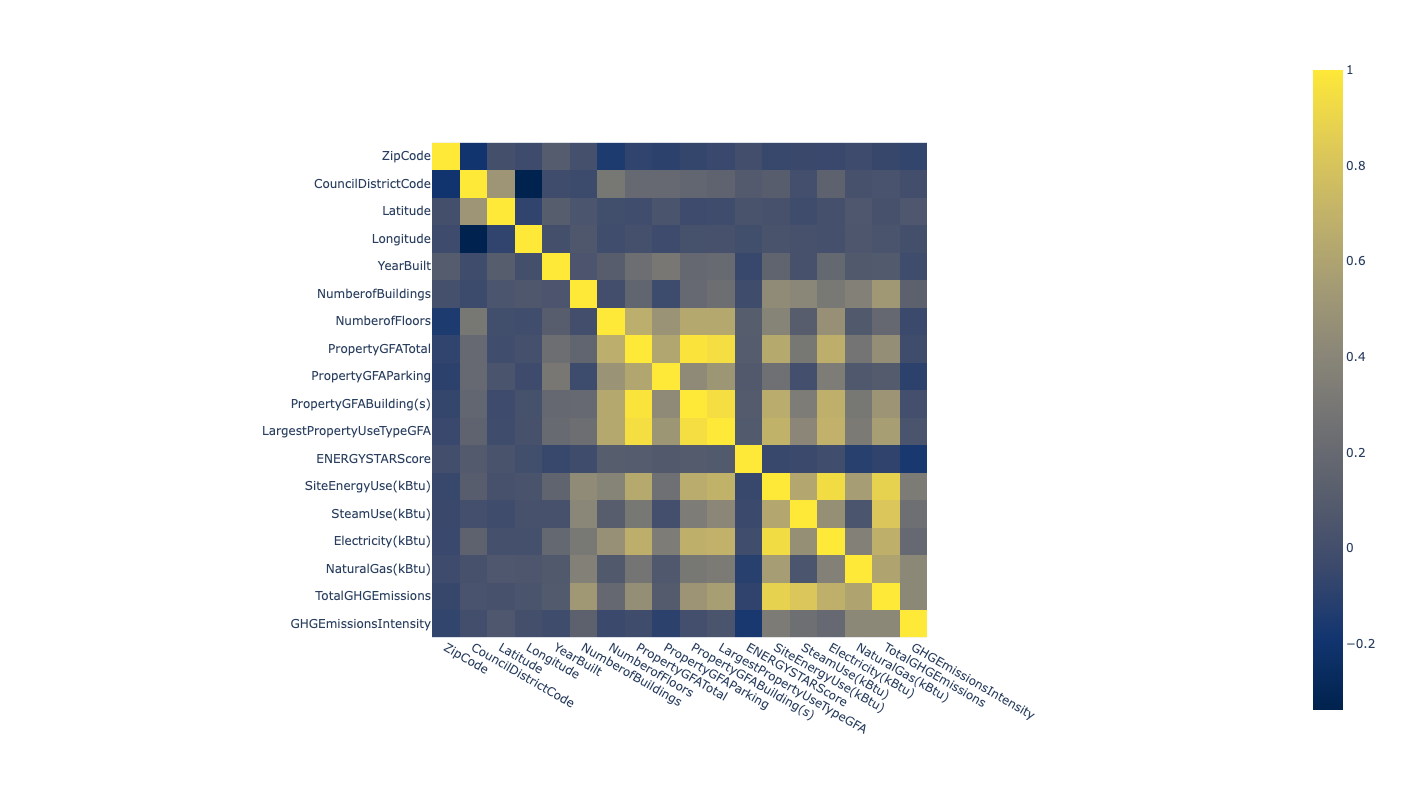

In [54]:
fig = px.imshow(df.select_dtypes(include=['int64', 'float64']).corr(), color_continuous_scale='cividis')
fig.update_layout(width=800, height=800)
fig.show()

Si je filtre ensuite les corrélations sur les variables cible:

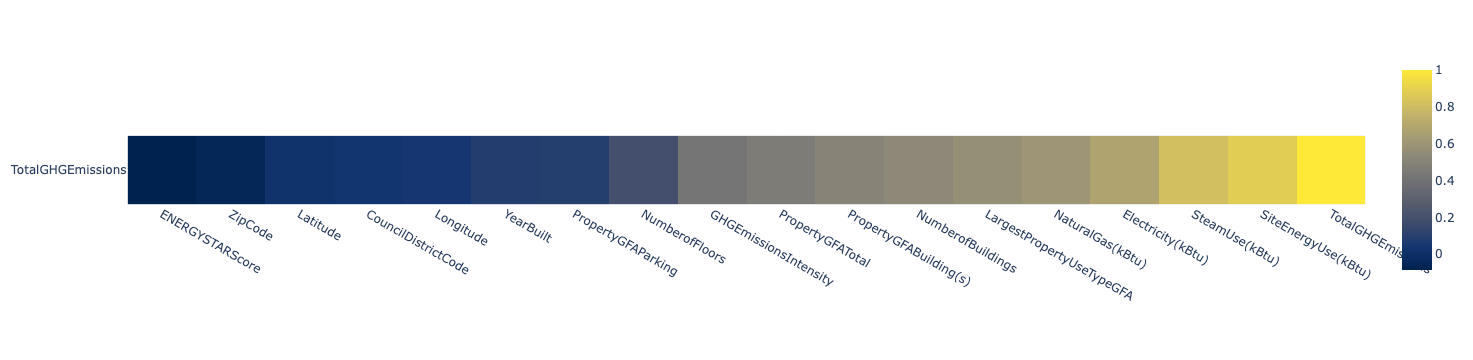

In [55]:
df_corr = df.select_dtypes(include=['int64', 'float64']).corr()
df_corr = df_corr.sort_values(by='TotalGHGEmissions')[['TotalGHGEmissions']].T
px.imshow(df_corr, color_continuous_scale='cividis')

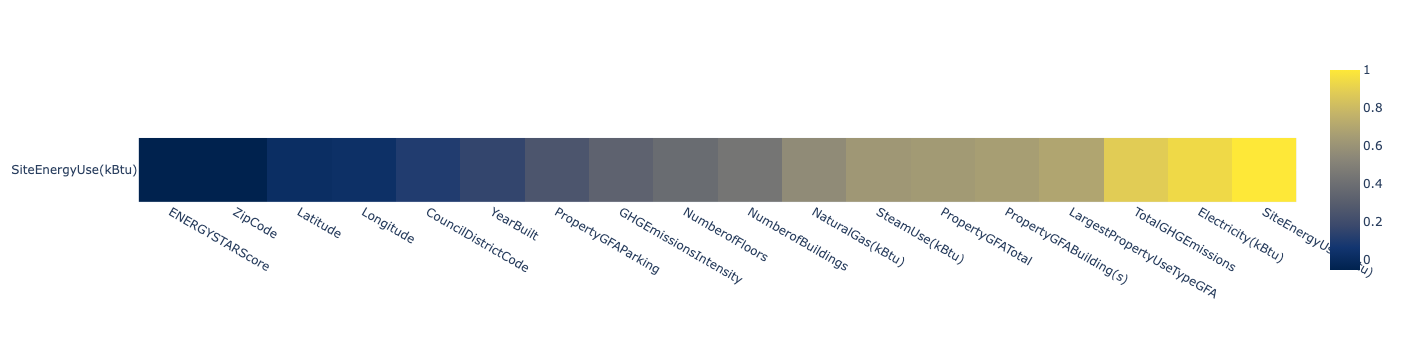

In [56]:
df_corr = df.select_dtypes(include=['int64', 'float64']).corr()
df_corr = df_corr.sort_values(by='SiteEnergyUse(kBtu)')[['SiteEnergyUse(kBtu)']].T
px.imshow(df_corr, color_continuous_scale='cividis')

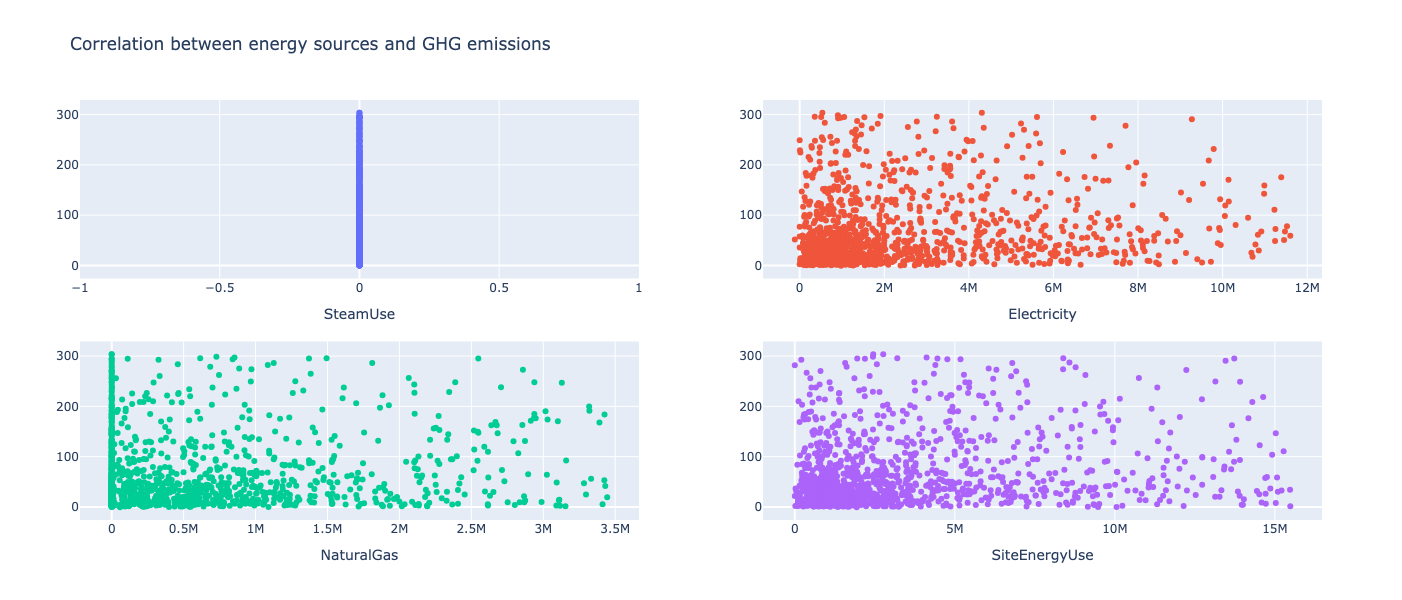

In [57]:

energy_vars = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUse(kBtu)']
fig = make_subplots(rows=2, cols=2)

for i, var in enumerate(energy_vars):
    row = (i//2)+1
    col=(i%2)+1
    
    fig.add_trace(go.Scatter(x=filter_out_outliers(df, var)[var], y=filter_out_outliers(df, 'TotalGHGEmissions')['TotalGHGEmissions'], mode='markers'), row=row, col=col)
    fig.update_xaxes(title_text=var[:-6], row=row, col=col)

fig.update_layout(height=600, width= 1000, showlegend=False, title='Correlation between energy sources and GHG emissions')
fig.show()

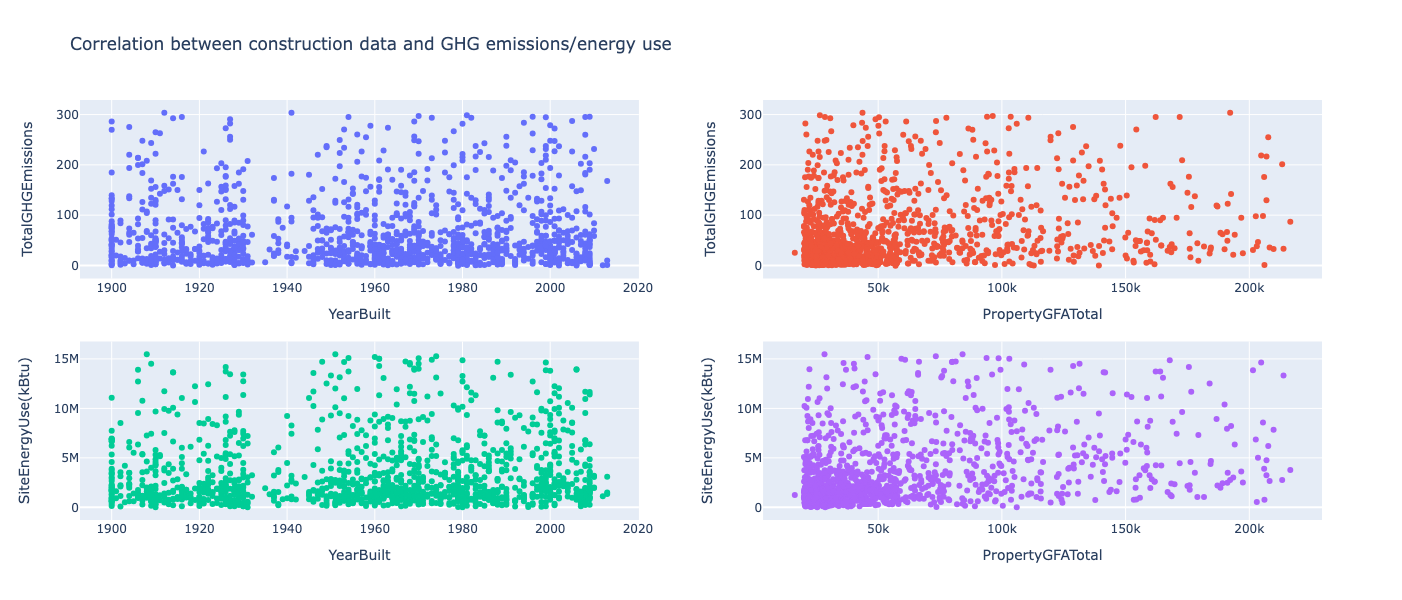

In [58]:
continuous_housing_vars = ['YearBuilt', 'PropertyGFATotal']
fig = make_subplots(rows=2, cols=2)

for j, target_var in enumerate(target_vars):
    for i, var in enumerate(continuous_housing_vars):
        row = (i//2)+ 1 + j
        col=(i%2)+1
            
        fig.add_trace(go.Scatter(x=filter_out_outliers(df, var)[var], y=filter_out_outliers(df, target_var)[target_var], mode='markers'), row=row, col=col)
        fig.update_xaxes(title_text=var, row=row, col=col)
        fig.update_yaxes(title_text= target_var, row=row, col=col)

fig.update_layout(height=600, width= 1000, showlegend=False, title='Correlation between construction data and GHG emissions/energy use')
fig.show()

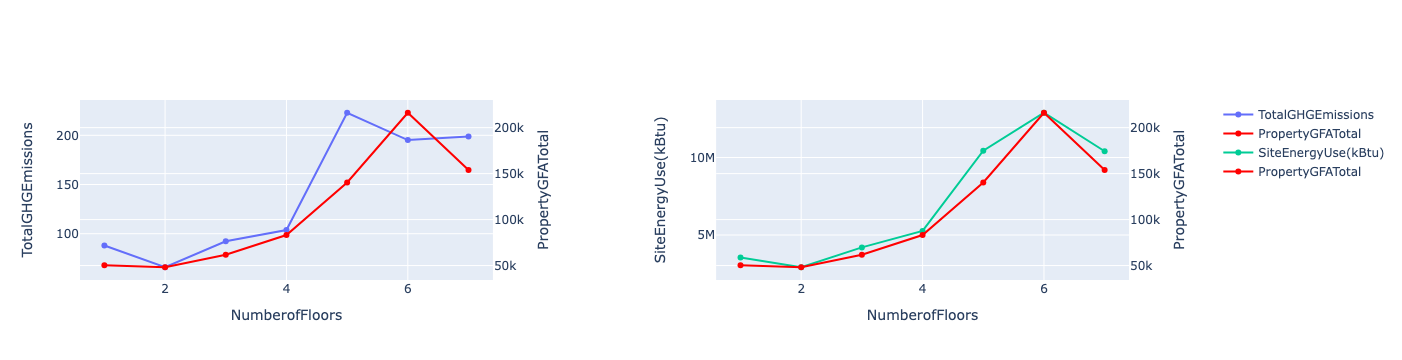

In [59]:
df_filtered = df.loc[df['NumberofFloors'].between(1,7)].groupby('NumberofFloors')[['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'PropertyGFATotal']].mean().reset_index()

fig = make_subplots(rows=1, cols=2, specs=[[{"secondary_y": True}, {"secondary_y": True}]])

for i, var in enumerate(target_vars):
    fig.add_trace(go.Scatter(x=df_filtered['NumberofFloors'], y=df_filtered[var], name=var), row=1, col=i+1, secondary_y=False)
    fig.update_yaxes(title_text=var, row=1, col=i+1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df_filtered['NumberofFloors'], y=df_filtered['PropertyGFATotal'], name='PropertyGFATotal', line=dict(color='red')), row=1, col=i+1, secondary_y=True)
    fig.update_yaxes(title_text='PropertyGFATotal', row=1, col=i+1, secondary_y=True)
    fig.update_xaxes(title_text='NumberofFloors', row=1, col=i+1)

fig.show()

Il apparaît que le jeu de données contient de nombreuses potentielles features qui permettraient de construire un modèle prédictif.  
La première matrice m'informe également de la potentielle multi-collinéarité entre certaines features.

### 2.4 Corrélation des features catégorielles

Pour évaluer le potentiel prédictif de mes features catégorielles, j'affiche des box plots groupés par modalité.

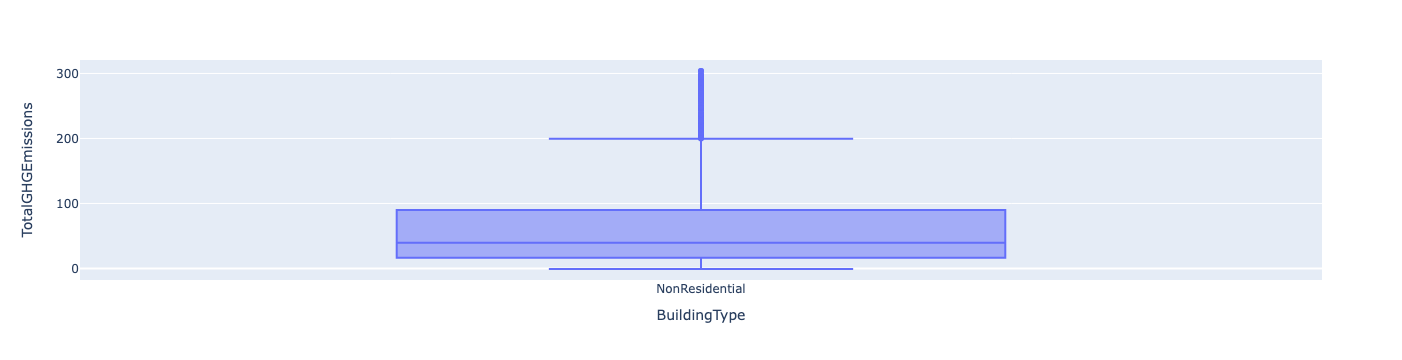

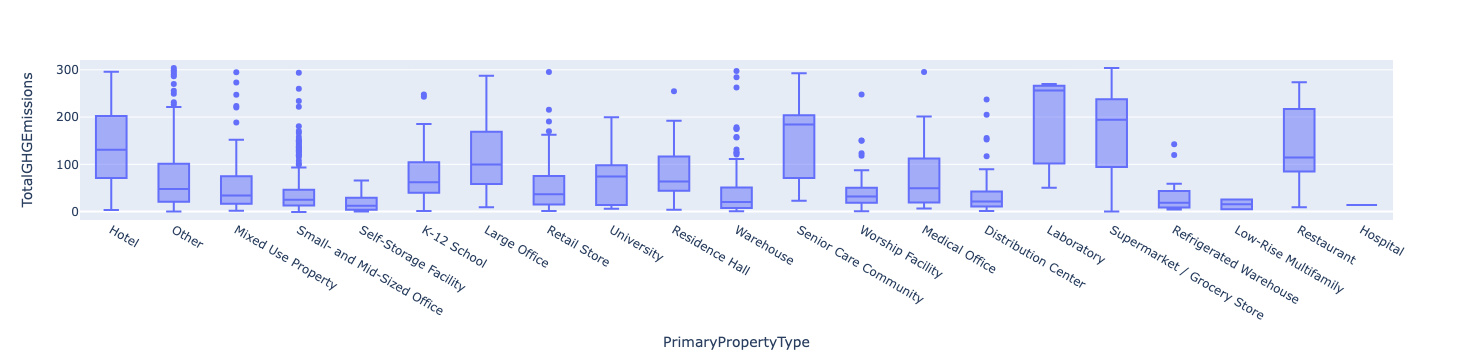

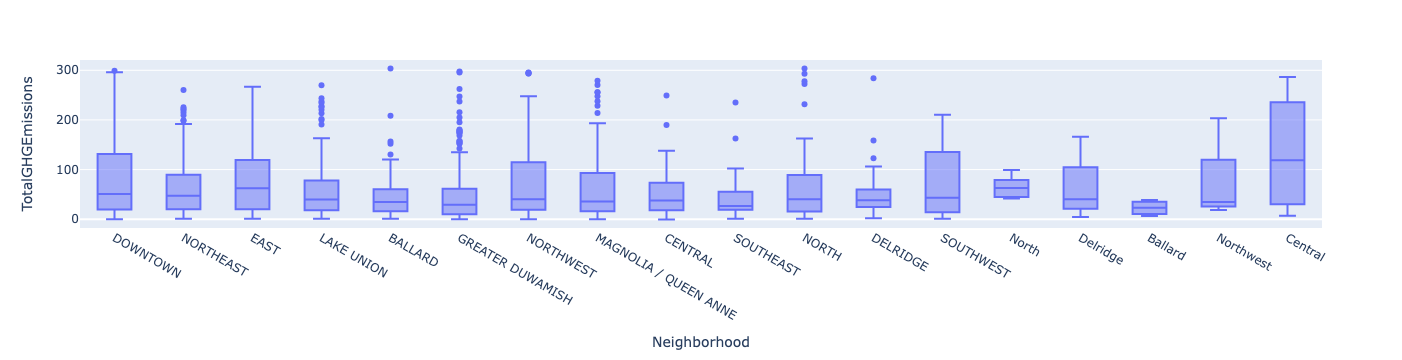

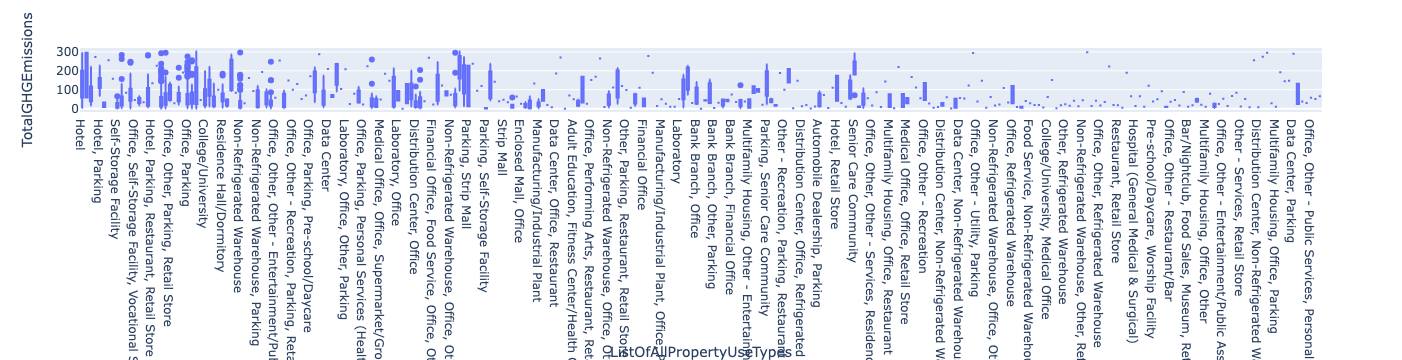

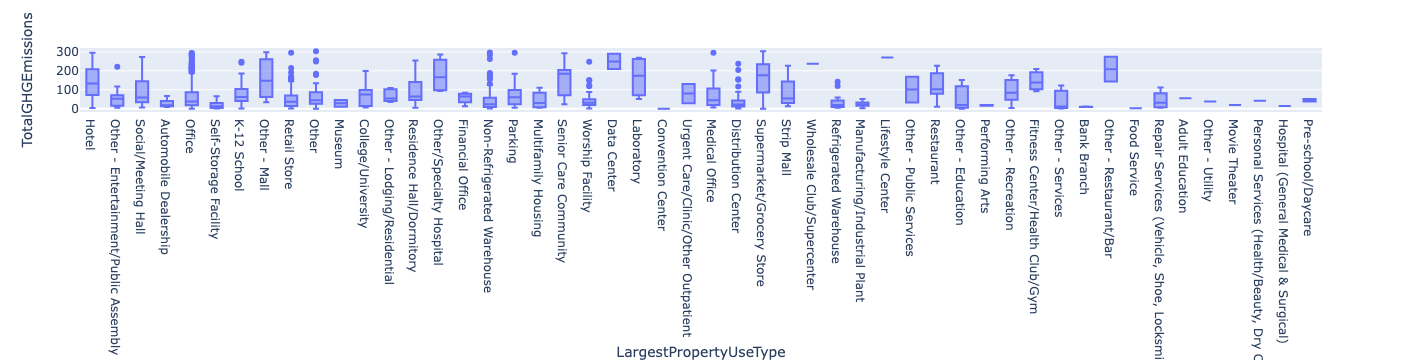

In [60]:
categorical_vars = df.select_dtypes(include='object')


for var in categorical_vars:
    fig = px.box(filter_out_outliers(df, target_vars[0]), x=var, y=target_vars[0])
    fig.show()

Bien que certaines features soient peu lisibles du fait de leur grande cardinalité, on observe des différences de distribution en fonction de la modalité, notamment sur le type d'usage principal du bâtiment.

L'analyse exploratoire a révélé:  
1. Des bâtiments au profil hétérogène, amenant à un jeu de données distribué de manière asymétrique avec quelques infrastructures publiques ou à grandes échelle à la consommation extrême comparé à la majorité des bâtiments non-résidentiels
2. Un potentiel prédictif certain au sein des features présentes dans le jeu de données, qui permettent d'être optimistes sur la construction d'un modèle efficace